In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, f1_score, recall_score,
                             precision_score, accuracy_score)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
import warnings
warnings.filterwarnings('ignore')

In [16]:
df = pd.read_csv('https://raw.githubusercontent.com/SumantaSethi/Bank-Customer-Churn-Prediction/main/Churn_Modelling_Clean.csv')
X = df.drop('Exited', axis=1)
y = df['Exited']

# Encoding

In [17]:
X_encoded = X.copy()
le_geo = LabelEncoder()
X_encoded['Geography'] = le_geo.fit_transform(X['Geography'])
le_gender = LabelEncoder()
X_encoded['Gender'] = le_gender.fit_transform(X['Gender'])


# SPLIT DATA

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Further split training into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Training: 6400, Validation: 1600, Test: 2000


# SCALE FEATURES

In [19]:
import os

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Create the 'models' directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save scaler
joblib.dump(scaler, 'models/scaler_deep_learning.pkl')

['models/scaler_deep_learning.pkl']

In [20]:
n_features = X_train_scaled.shape[1]
print(f"Building model with {n_features} features")

Building model with 10 features


# BUILD NEURAL NETWORK

In [29]:
def create_model(n_features):
    model = keras.Sequential([
        # Input layer
        layers.Dense(128, activation='relu', input_shape=(n_features,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Hidden layer 1
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Hidden layer 2
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])

    return model

model = create_model(X_train_scaled.shape[1])

print("\nModel Architecture:")
model.summary()


Model Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,673 (49.50 KB)

 Trainable params: 12,225 (47.75 KB)

 Non-trainable params: 448 (1.75 KB)

# COMPILE MODEL

In [22]:
class_weight = {
    0: 1.0,
    1: (y_train == 0).sum() / (y_train == 1).sum()
}

print(f"Class weights: {class_weight}")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.AUC(name='auc'),
        keras.metrics.Recall(name='recall')
    ]
)

Class weights: {0: 1.0, 1: np.float64(3.9079754601226995)}


# CALLBACKS

In [23]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

# TRAIN MODEL

In [24]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5924 - auc: 0.6674 - loss: 1.1432 - recall: 0.6566 - val_accuracy: 0.7013 - val_auc: 0.7928 - val_loss: 0.6040 - val_recall: 0.7638 - learning_rate: 0.0010
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7006 - auc: 0.7748 - loss: 0.9173 - recall: 0.7164 - val_accuracy: 0.7431 - val_auc: 0.8133 - val_loss: 0.5192 - val_recall: 0.7117 - learning_rate: 0.0010
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7072 - auc: 0.7905 - loss: 0.8787 - recall: 0.7070 - val_accuracy: 0.7513 - val_auc: 0.8238 - val_loss: 0.5052 - val_recall: 0.7178 - learning_rate: 0.0010
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7279 - auc: 0.7990 - loss: 0.8604 - recall: 0.7189 - val_accuracy: 0.7475 - val_auc: 0.8326 - val_loss: 0.5028 - val_recall: 0.7393 - learning_rate: 0.0010
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7285 - auc: 0.8117 - loss: 0.8398 - recal

# EVALUATE

In [25]:
y_pred_proba = model.predict(X_test_scaled).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n📊 METRICS:")
print(f"   Accuracy:  {accuracy:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1 Score:  {f1:.4f}")
print(f"   ROC-AUC:   {roc_auc:.4f}")

print("\n📋 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, target_names=['Stayed', 'Churned']))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

📊 METRICS:
   Accuracy:  0.7860
   Precision: 0.4833
   Recall:    0.7469
   F1 Score:  0.5869
   ROC-AUC:   0.8565

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Stayed       0.92      0.80      0.86      1593
     Churned       0.48      0.75      0.59       407

    accuracy                           0.79      2000
   macro avg       0.70      0.77      0.72      2000
weighted avg       0.84      0.79      0.80      2000



# Visualizations

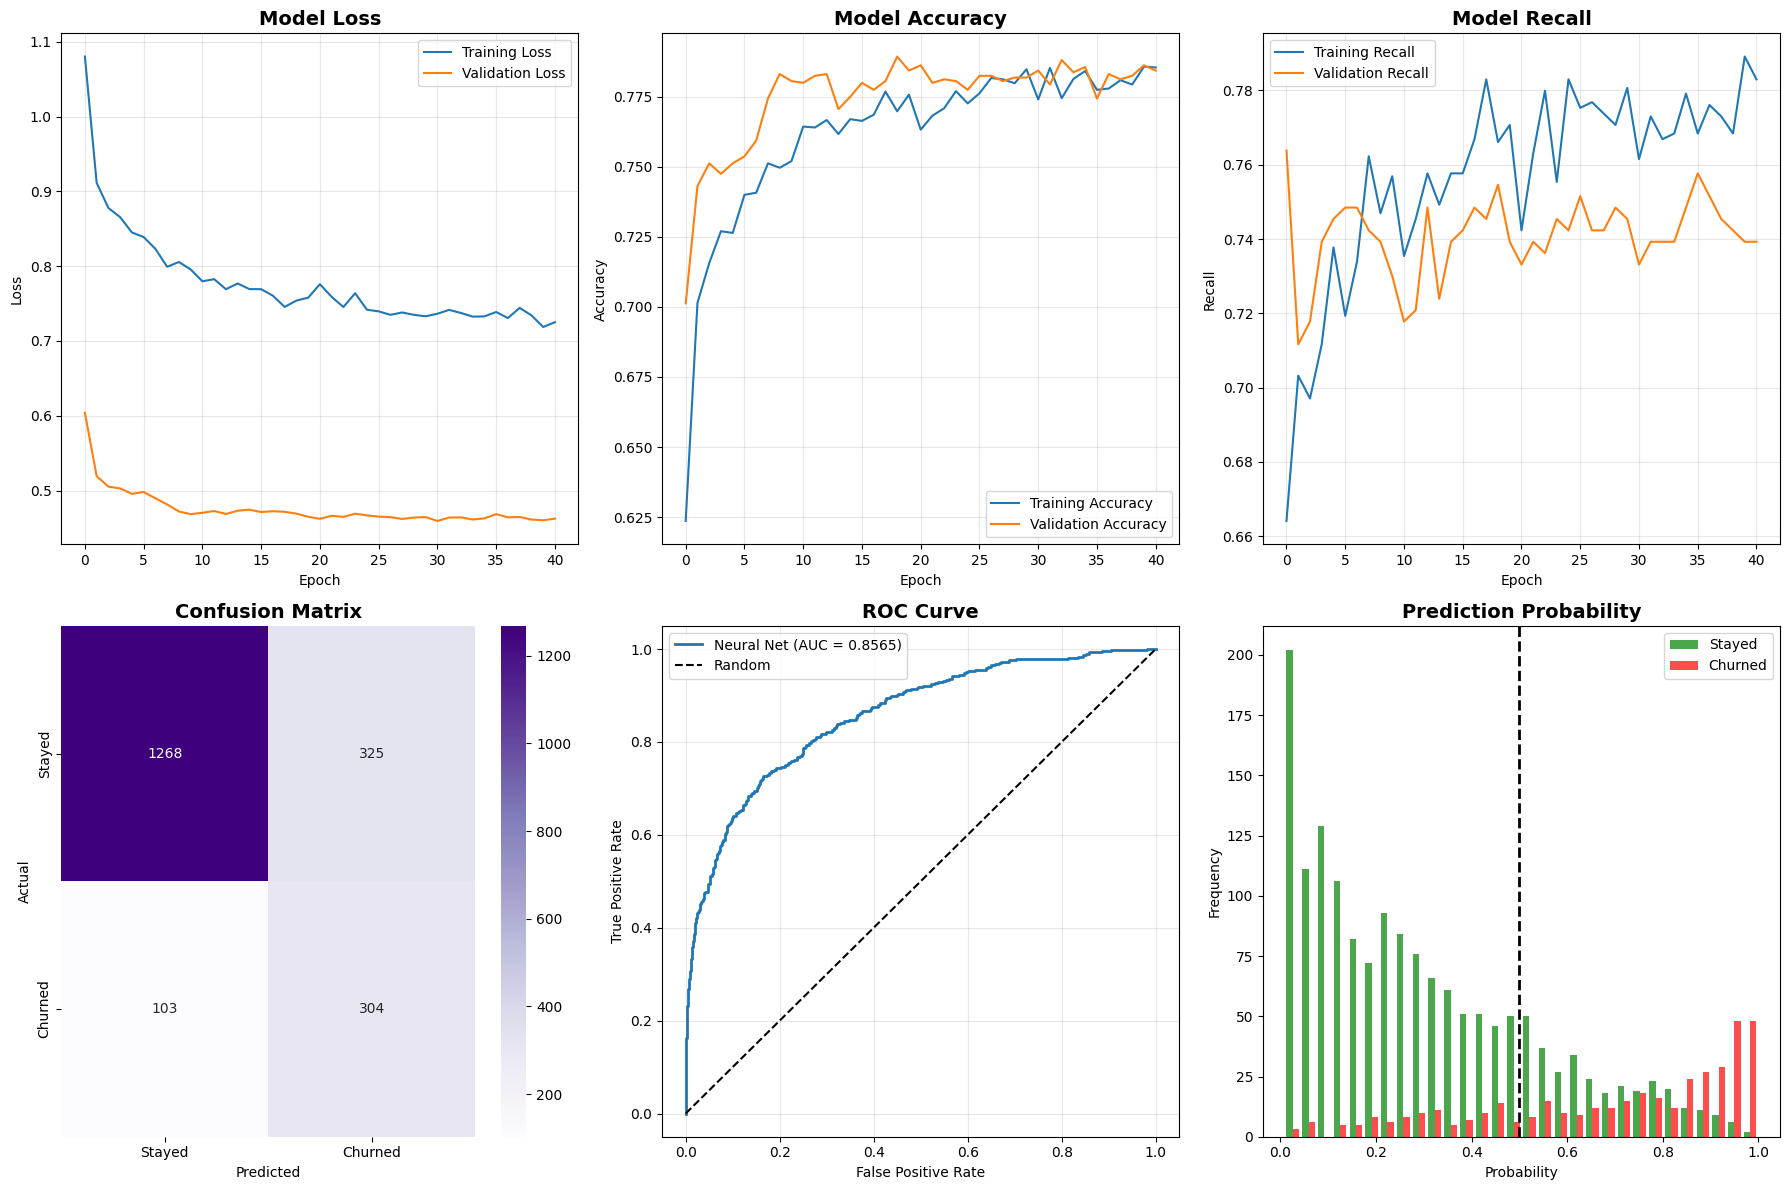

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Training History - Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Training History - Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Training History - Recall
axes[0, 2].plot(history.history['recall'], label='Training Recall')
axes[0, 2].plot(history.history['val_recall'], label='Validation Recall')
axes[0, 2].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Recall')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=axes[1, 0],
            xticklabels=['Stayed', 'Churned'],
            yticklabels=['Stayed', 'Churned'])
axes[1, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_xlabel('Predicted')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1, 1].plot(fpr, tpr, linewidth=2, label=f'Neural Net (AUC = {roc_auc:.4f})')
axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1, 1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# Prediction Distribution
axes[1, 2].hist([y_pred_proba[y_test==0], y_pred_proba[y_test==1]],
               bins=30, label=['Stayed', 'Churned'],
               color=['green', 'red'], alpha=0.7)
axes[1, 2].axvline(x=0.5, color='black', linestyle='--', linewidth=2)
axes[1, 2].set_title('Prediction Probability', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Probability')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].legend()

plt.tight_layout()
plt.savefig('models/deep_learning_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# SAVE MODEL

In [27]:
model.save('models/deep_learning.h5')
model.save('models/deep_learning.keras')
print("✅ Saved to 'models/deep_learning.h5' and .keras")

print("\n" + "="*80)
print("DEEP LEARNING MODEL COMPLETED!")
print("="*80)

print("\n📊 SUMMARY:")
print(f"   Architecture: 128→64→32→1 neurons")
print(f"   Activation: ReLU (hidden), Sigmoid (output)")
print(f"   Dropout: 0.3, 0.3, 0.2")
print(f"   Batch Normalization: Yes")
print(f"   Epochs trained: {len(history.history['loss'])}")
print(f"   Final metrics - Acc: {accuracy:.4f}, Recall: {recall:.4f}, AUC: {roc_auc:.4f}")

✅ Saved to 'models/deep_learning.h5' and .keras

DEEP LEARNING MODEL COMPLETED!

📊 SUMMARY:
   Architecture: 128→64→32→1 neurons
   Activation: ReLU (hidden), Sigmoid (output)
   Dropout: 0.3, 0.3, 0.2
   Batch Normalization: Yes
   Epochs trained: 41
   Final metrics - Acc: 0.7860, Recall: 0.7469, AUC: 0.8565
